In [77]:
import numpy as np
frame_offsets=np.linspace(-2.5,-0.5,21)

VirtualGImbalに送る設定用のJSONファイルを生成する

In [78]:
import json

# with open('output.json', 'w') as f:
#     obj={"frame_offset":0.0, "path_prefix":str(0.0)}
#     json.dump(obj, f)

複数の設定をそれぞれjsonに書き出して実行
build/以下におく


In [79]:
for fo in frame_offsets:
    with open('../build/frame_offset_' + format(fo,'1.4f') + '.json', 'w') as f:
        obj={"frame_offset":fo, "path_prefix":format(fo,'1.4f')}
        json.dump(obj, f)

VirtualGimbalを順に起動する

オフセット変えたときの4Aをプロットする

In [106]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換
    # data = [print(row) for row in data]  # 文字列を数値に変換
    # X軸に時間を、Y軸にデータをセット
    t = [row[legends.index('Frame')] for row in data]
    rxw = [row[legends.index('rx')] for row in data]
    ryw = [row[legends.index('ry')] for row in data]
    rzw = [row[legends.index('rz')] for row in data]
    return t, rxw, ryw, rzw

# 角加速度を計算する関数を定義。戻り値の配列の長さが元の配列より１短い事に注意。
import numpy as np

def getAngularAcceleration(angular_velocity, sampling_rate):
    return (np.array(angular_velocity)[1:]-np.array(angular_velocity)[:-1])*sampling_rate

def getAverageOfAbsAngularAcceleration(angular_velocity, sampling_rate):
    return np.average(np.abs(getAngularAcceleration(angular_velocity,sampling_rate)))

def getTime(angular_velocity,sampling_rate):
    return np.linspace(0,len(angular_velocity)-1,len(angular_velocity))/sampling_rate

def getA4(angular_velocity,sampling_rate, length):
    time = getTime(angular_velocity,sampling_rate)
    a4 = []
    time_average = []
    for i in range(0,len(angular_velocity)-1-length,length):
        a4.append(getAverageOfAbsAngularAcceleration(angular_velocity[i:i+length],sampling_rate))
        time_average.append(np.average(time[i:i+length])) 
    return time_average, a4

def plotA4s(angular_velocitys,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):
    plt.figure(figsize=(10,6))

    if legends is not None:
        for av,lb in zip(angular_velocitys,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4,label=lb)
    else:
        for av in angular_velocitys:
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4)

    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Average of Angular Acceleration [rad/s^2]')          
    plt.legend()
    plt.grid()




In [107]:
def exec_vg(offset):
    cmd = './pixelwise_stabilizer -i /home/yoshiaki/Videos/C0006.MP4 -c ILCE-6500i -l SEL1670Z -j ./records/2022-10-04_12-56-14.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [82]:
for fo in frame_offsets:
    exec_vg(fo)

videoPass /home/yoshiaki/Videos/C0006.MP4
Before:	-0.007066,-0.109360,-0.001279,0.007084
After:	-0.005873,0.164734,0.001499,-0.008422
1100 / 1171minimum_correlation_frame108
min_value:0.58438
minimum_correlation_subframe:-0.2053
107.795
1100 / 1171minimum_correlation_frame829
min_value:0.624191
minimum_correlation_subframe:0.1011
829.101
Table:
(499,2529.254145), a:4.184212 b=441.332115
0
videoPass /home/yoshiaki/Videos/C0006.MP4
Before:	-0.007066,-0.109360,-0.001279,0.007084
After:	-0.005873,0.164734,0.001499,-0.008422
1100 / 1171minimum_correlation_frame108
min_value:0.58438
minimum_correlation_subframe:-0.2053
107.795
1100 / 1171minimum_correlation_frame829
min_value:0.624191
minimum_correlation_subframe:0.1011
829.101
Table:
(499,2529.254145), a:4.184212 b=441.332115
0
videoPass /home/yoshiaki/Videos/C0006.MP4
Before:	-0.007066,-0.109360,-0.001279,0.007084
After:	-0.005873,0.164734,0.001499,-0.008422
1100 / 1171minimum_correlation_frame108
min_value:0.58438
minimum_correlation_subf

全部のグラフを結合して表示してみる

In [83]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:]
    else:
        datas = np.append(datas,data[1:],axis=0)

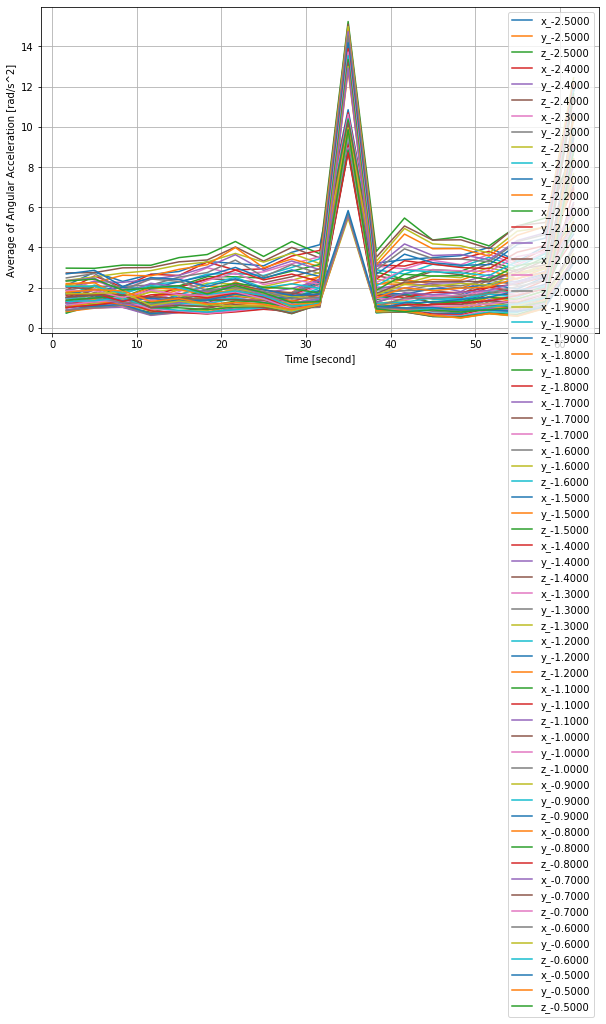

In [84]:
plotA4s(datas,legend,sampling_rate=30,length=100)

In [95]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:2]
    else:
        datas = np.append(datas,data[1:2],axis=0)

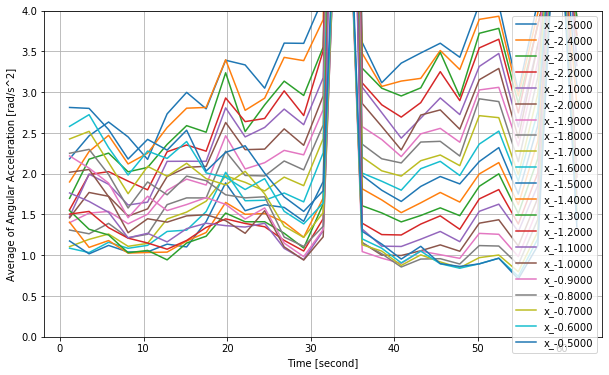

In [96]:
plotA4s(datas,legend,sampling_rate=30,length=70,ylim=[0,4])

In [91]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    # legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[2:3]
    else:
        datas = np.append(datas,data[2:3],axis=0)

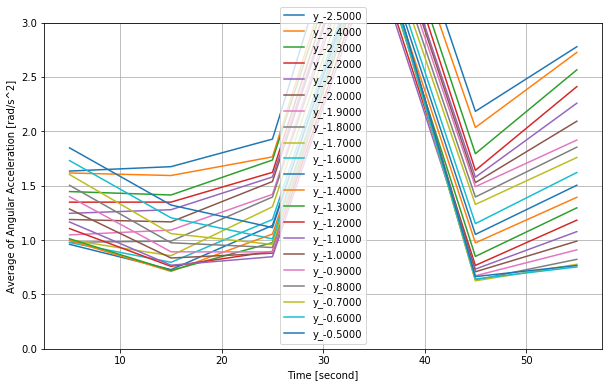

In [94]:
plotA4s(datas,legend,sampling_rate=30,length=300,ylim=[0,3])

iPhoneのデータセットの結果は分かった。ではVirtualGimbalの結果は？

In [123]:
def exec_vg_sd(offset):
    cmd = './pixelwise_stabilizer -i /home/yoshiaki/syukugawara/C0003.MP4 -c ILCE-6500 -l SEL1670Z -j ./records/2022-10-04_12-56-14.json -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

   

In [124]:
frame_offsets=np.linspace(-50,50,21)

for fo in frame_offsets:
    with open('../build/frame_offset_' + format(fo,'1.4f') + '.json', 'w') as f:
        obj={"frame_offset":fo, "path_prefix":format(fo,'1.4f')}
        json.dump(obj, f)

for fo in frame_offsets:
    exec_vg_sd(fo)

videoPass /home/yoshiaki/syukugawara/C0003.MP4
Before:	-0.007066,-0.109360,-0.001279,0.007084
After:	-0.005873,0.164734,0.001499,-0.008422
1100 / 1171minimum_correlation_frame33
min_value:0.852801
minimum_correlation_subframe:-0.0367
32.9633
1100 / 1171minimum_correlation_frame36
min_value:0.790312
minimum_correlation_subframe:-0.1178
35.8822
1100 / 1171minimum_correlation_frame40
min_value:0.891502
minimum_correlation_subframe:0.1461
40.1461
1100 / 1171minimum_correlation_frame50
min_value:0.916111
minimum_correlation_subframe:0.0425
50.0425
1100 / 1171minimum_correlation_frame4
min_value:0.830661
minimum_correlation_subframe:0.0898
4.0898
1100 / 1171minimum_correlation_frame6
min_value:0.999639
minimum_correlation_subframe:0.1351
6.1351
1100 / 1171minimum_correlation_frame9
min_value:1.11804
minimum_correlation_subframe:-1.7881
7.2119
1100 / 1171minimum_correlation_frame60
min_value:1.14571
minimum_correlation_subframe:0.3322
60.3322
1100 / 1171minimum_correlation_frame35
min_value:0

In [125]:
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:]
    else:
        datas = np.append(datas,data[1:],axis=0)


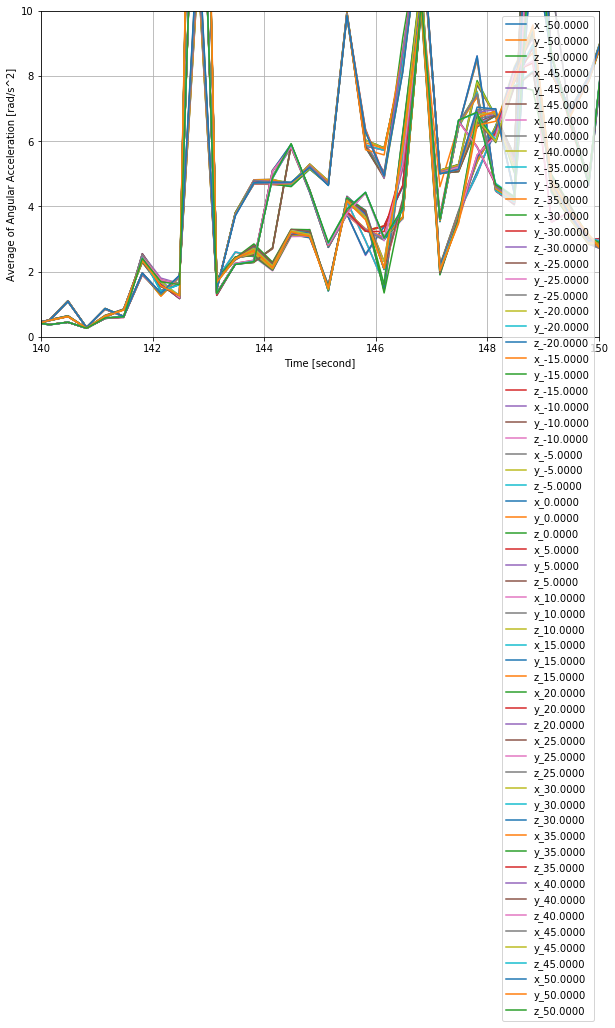

In [128]:
plotA4s(datas,legend,sampling_rate=30,length=10,xlim=[140,150],ylim=[0,10])

In [130]:
# legend = []
xdatas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # # legendを書く
    # legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if xdatas is None:
        xdatas = data[1:2]
    else:
        xdatas = np.append(xdatas,data[1:2],axis=0)

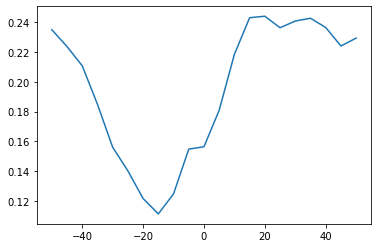

In [135]:
plt.plot(frame_offsets,xdatas[:,0])


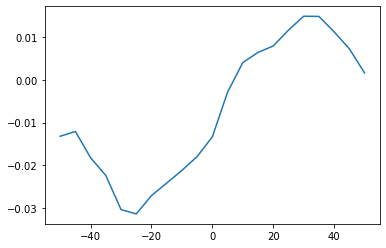

In [136]:
plt.plot(frame_offsets,xdatas[:,1000])